In [344]:
import vertexai
project_id = "possible-arch-424719-s5"
vertexai.init(project=project_id, location="us-central1")

In [345]:
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/73391336_m2ZRf.png" #! TABLE
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/67066301_pbhSq.png" #! TABLE
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/51832118_C1mq2.png" #! COMPLEX SCENARIO, SCREENSHOT, NOT PERFECT
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/54690809_rdxKZ.png" #! COMPLEX SCENARIO, IDE, WORKS
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/38854857_624Mu.png" #! COMPLEX SCENARIO, FLOW, MEH
# img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/44833863_Tylgo.png" #! COMPLEX SCENARIO, FLOW, WORKS
img_url = "/home/wfd/Desktop/York/images/Non_Duplicates/46108052_IgWMn.png"

question = """What is the problem?"""

# Multimodal Gemini

In [346]:
from google.cloud import storage

def upload_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    print(f"Uploading {source_file_name} to {destination_blob_name} in bucket {bucket_name}")

    blob.upload_from_filename(source_file_name)

    print(f"File {source_file_name} uploaded to {destination_blob_name}.")
    img_uri = f"gs://{bucket_name}/{destination_blob_name}"
    print(f"Google Storage URI: {img_uri}")
    return img_uri

# Example usage
bucket_name = "york-project"
img_uri = upload_to_gcs(bucket_name, img_url, img_url.split("/")[-1])

Uploading /home/wfd/Desktop/York/images/Non_Duplicates/46108052_IgWMn.png to 46108052_IgWMn.png in bucket york-project
File /home/wfd/Desktop/York/images/Non_Duplicates/46108052_IgWMn.png uploaded to 46108052_IgWMn.png.
Google Storage URI: gs://york-project/46108052_IgWMn.png


In [347]:
from vertexai.generative_models import GenerativeModel, Part
    
generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}

def generate(prompt, image_path):
    image_path = "gs://york-project/" + image_path.split("/")[-1]
    image = Part.from_uri(image_path, "image/png")

    model = GenerativeModel(
        "gemini-1.5-flash-001",
    )

    responses = model.generate_content(
        [prompt, image],        
        generation_config=generation_config,
        stream=True,
    )

    response = []
    for text in responses:
        try:
            response.append(text.text)
        except:
            pass
        
    text_response = "".join(response)
    # print(text_response)
    return text_response

In [348]:
# Example usage
prompt = """
    What is on the image ? 
    Describe it with the most details you can as a bullet list.
    Do not add any other information than the bullet list.
"""

# generate(prompt, img_uri)

# Text detection

In [349]:
%pip install google-cloud-vision

Note: you may need to restart the kernel to use updated packages.


In [350]:
import cv2

def add_text_to_image(image_path, results, thickness=2):
  # Load the image from the raw_image
  image = cv2.imread(image_path)

  for detected_text in results:
    bounds = detected_text['bounds']
    # Coordinates of the bounding box
    x_min, y_min, x_max, y_max = int(bounds[0][0]), int(bounds[0][1]), int(bounds[1][0]), int(bounds[1][1])

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
    else:
        height, width, _ = image.shape
        # Draw the rectangle on the image
        color = (0, 0, 255)  # Color of the rectangle (Green in BGR format)
        # If the thickness is -1, set the color to the pixel right beside the box
        if (thickness == -1):
          y = y_max + 1 if y_max + 1 < height else y_max - 1
          x = x_min - 1 if x_min - 1 >= 0 else x_min + 1
          color = image[y, x]
          color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

  return image

### NMS

In [351]:
import numpy as np

def non_max_suppression(boxes, overlap_thresh):
    """
    Perform Non-Maximum Suppression (NMS) on bounding boxes.

    Args:
        boxes (list of dict): List of bounding boxes with format {"text": str, "bounds": list of (x, y) tuples}.
        overlap_thresh (float): Threshold for overlap. Boxes with IoU > overlap_thresh will be suppressed.

    Returns:
        list of dict: List of bounding boxes after NMS.
    """
    if len(boxes) == 0:
        return []

    # Convert bounding boxes to numpy array format
    boxes_np = []
    for box in boxes:
        x_coords = [vertex[0] for vertex in box['bounds']]
        y_coords = [vertex[1] for vertex in box['bounds']]
        x1, y1 = min(x_coords), min(y_coords)
        x2, y2 = max(x_coords), max(y_coords)
        boxes_np.append([x1, y1, x2, y2])

    boxes_np = np.array(boxes_np)
    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = boxes_np[:, 2]
    y2 = boxes_np[:, 3]

    # Compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Initialize the list of picked indexes
    pick = []

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    # Return only the bounding boxes that were picked
    return [boxes[i] for i in pick]

# Example usage
# filtered_detection = non_max_suppression(detection, overlap_thresh=0.3)
# print(f"Removed {len(detection) - len(filtered_detection)} boxes")

### Paragraph OCR

In [352]:
from google.cloud import vision
from google.api_core.client_options import ClientOptions
import io

# Step 2: Specify the project ID and initialize the Vision API client
client_options = ClientOptions(quota_project_id=project_id)
client = vision.ImageAnnotatorClient(client_options=client_options)

def detect_text(path):
    """Detects text in the file and extracts paragraphs."""
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Use DOCUMENT_TEXT_DETECTION for detailed text structure
    response = client.document_text_detection(image=image)
    annotation = response.full_text_annotation

    paragraphs = []

    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                paragraph_text = ''
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    paragraph_text += word_text + ' '
                bounds = [(vertex.x, vertex.y) for vertex in paragraph.bounding_box.vertices]
                paragraphs.append({"text": paragraph_text.strip(), "bounds": [bounds[0], bounds[2]]})

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(response.error.message))

    return paragraphs

paragraphs = detect_text(img_url)
print(paragraphs[0])

{'text': 'Run StorageConfiguration | OCTest', 'bounds': [(3, 20), (200, 29)]}


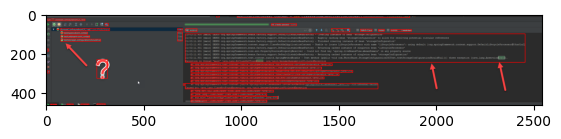

In [353]:
import matplotlib.pyplot as plt

filtered_paragraphs = non_max_suppression(paragraphs, overlap_thresh=0.3)
modified_img = add_text_to_image(img_url, filtered_paragraphs)

plt.imshow(cv2.cvtColor(modified_img, cv2.COLOR_BGR2RGB))

### Merge overlapping boxes

In [354]:
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (tuple): Bounding box with format [(x1, y1), (x2, y2)].
        box2 (tuple): Bounding box with format [(x1, y1), (x2, y2)].

    Returns:
        float: IoU value.
    """
    x1 = max(box1[0][0], box2[0][0])
    y1 = max(box1[0][1], box2[0][1])
    x2 = min(box1[1][0], box2[1][0])
    y2 = min(box1[1][1], box2[1][1])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[1][0] - box1[0][0]) * (box1[1][1] - box1[0][1])
    box2_area = (box2[1][0] - box2[0][0]) * (box2[1][1] - box2[0][1])
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

In [355]:

def merge_overlapping_boxes(original_boxes, threshold=0.5):
    """
    Merges overlapping bounding boxes based on the IoU threshold.

    Args:
    - boxes (list of dict): List of bounding boxes with 'text' and 'bounds' keys.
    - threshold (float): IoU threshold for merging boxes.

    Returns:
    - merged_boxes (list of dict): List of merged bounding boxes.
    """
    boxes = original_boxes.copy()

    if len(boxes) == 0:
        return []

    merged_boxes = []

    while boxes:
        base_box = boxes.pop(0)
        base_bounds = base_box['bounds']
        base_text = base_box['text']
        merged = False

        i = 0
        while i < len(boxes):
            if compute_iou(base_bounds, boxes[i]['bounds']) > threshold:
                # Merge the boxes
                x1 = min(base_bounds[0][0], boxes[i]['bounds'][0][0])
                y1 = min(base_bounds[0][1], boxes[i]['bounds'][0][1])
                x2 = max(base_bounds[1][0], boxes[i]['bounds'][1][0])
                y2 = max(base_bounds[1][1], boxes[i]['bounds'][1][1])
                merged_bounds = [(x1, y1), (x2, y2)]
                base_text += ' ' + boxes[i]['text']
                base_bounds = merged_bounds
                boxes.pop(i)
                merged = True
            else:
                i += 1

        merged_boxes.append({"text": base_text.strip(), "bounds": base_bounds})

    return merged_boxes

In [356]:
merged_boxes = merge_overlapping_boxes(filtered_paragraphs, threshold=0.001)

### Sort bounding boxes

Function to read from right to left and top to bottom

In [357]:
def sort_bounding_boxes(boxes):
    # Sort bounding boxes by y-coordinate (top to bottom)
    boxes.sort(key=lambda box: box['bounds'][0][1])

    # Sort bounding boxes by x-coordinate (left to right) within each row
    rows = []
    current_row = []
    prev_y = None

    for box in boxes:
        if not prev_y or abs(box['bounds'][0][1] - prev_y) <= 10:
            current_row.append(box)
        else:
            current_row.sort(key=lambda box: box['bounds'][0][0])
            rows.append(current_row)
            current_row = [box]
        prev_y = box['bounds'][0][1]

    if current_row:
        current_row.sort(key=lambda box: box['bounds'][0][0])
        rows.append(current_row)

    # Flatten the sorted rows into a single list
    sorted_boxes = [box for row in rows for box in row]

    return sorted_boxes

### Section extraction

Clean the image of the text by rendering boxes of the color below the text

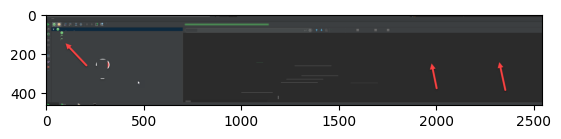

In [358]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread(img_url)
# Remove the detected text from the image
cleaned_img = add_text_to_image(img_url, merged_boxes, -1)

plt.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_BGR2RGB))

In [359]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def detect_sections_more_refined(image, cleaned_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(cleaned_img, cv2.COLOR_BGR2GRAY)

    # Use Canny edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Sum pixel values along the vertical axis
    vertical_sum = np.sum(edges, axis=0)

    # Normalize the vertical sum to the range 0 to 255
    vertical_sum_normalized = (vertical_sum / np.max(vertical_sum)) * 255

    # Use find_peaks to identify significant peaks
    peaks, _ = find_peaks(vertical_sum_normalized, height=100, distance=100)

    # Draw these boundaries on the original image
    boundary_image = image.copy()
    sections = []
    for peak in peaks:
        sections.append(peak)
        cv2.line(boundary_image, (peak, 0), (peak, boundary_image.shape[0]), (255, 0, 0), 2)

    # # Display the image with boundaries
    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(boundary_image, cv2.COLOR_BGR2RGB))
    # plt.title('Image with Boundaries')
    # plt.show()

    return sections

# Apply the more refined function to the new image
sections = detect_sections_more_refined(image, cleaned_img)
print(f"Detected {len(sections) - 1} section(s)")

Detected 1 section(s)


For now, the sections are only vertical but I should include horizontal as well

In [360]:
# If the first section is not at the start of the image, add a section at the start
if (sections[0] != 0):
    sections.insert(0, 0)
if (sections[-1] != image.shape[1]):
    sections.append(image.shape[1])

rectangles_bbox = []
# Set the bounds of the rectangles_bbox as top left and bottom right between the sections
for i in range(len(sections) - 1):
    rectangles_bbox.append({"bounds": [(sections[i], 0), (sections[i + 1], image.shape[0])]})
print(rectangles_bbox)

[{'bounds': [(0, 0), (28, 461)]}, {'bounds': [(28, 0), (700, 461)]}, {'bounds': [(700, 0), (2542, 461)]}]


Function to only get the text in a section, allows to read text in correct order section by section.

In [361]:
def calculate_overlap_area(box1, box2):
    x1 = max(box1[0][0], box2[0][0])
    y1 = max(box1[0][1], box2[0][1])
    x2 = min(box1[1][0], box2[1][0])
    y2 = min(box1[1][1], box2[1][1])

    overlap_width = max(0, x2 - x1)
    overlap_height = max(0, y2 - y1)

    return overlap_width * overlap_height

def get_text_in_rectangle(merged_boxes_, rec):
    for i in range(len(merged_boxes_)):
        box = merged_boxes_[i]
        box_bounds = box['bounds']
        max_overlap_area = 0
        best_section_id = 0

        for rect_id in range(len(rec)):
            rect_bounds = rec[rect_id]['bounds']
            overlap_area = calculate_overlap_area(box_bounds, rect_bounds)

            if overlap_area > max_overlap_area:
                max_overlap_area = overlap_area
                best_section_id = rect_id

        merged_boxes_[i]["section_id"] = best_section_id

    section_texts = ['' for _ in range(len(rec))]
    for box in merged_boxes_:
        section_id = box["section_id"]
        if section_id < len(section_texts):
            section_texts[section_id] += box['text'] + '\n'

    return section_texts

section_text = []
sorted_boxes = sort_bounding_boxes(merged_boxes)
if len(rectangles_bbox) == 0:
    print("Only one vertical section detected.\n")
    for i in range(len(sorted_boxes)):
        print(f"{sorted_boxes[i]['text']}")
else:
    section_texts = get_text_in_rectangle(sorted_boxes, rectangles_bbox)
    for i, text in enumerate(section_texts):
        print(f"Text of section {i}:\n{text}\n")

Text of section 0:
+
?
+


Text of section 1:
Run StorageConfiguration | OCTest
糕
OK
StorageConfiguration | OCTest ( com.PhotoShare )
93ms
O testGetBeanFromContext
OK
testApplicationContext
40ms 25ms 28ms
O testStorageConfigurationShouldFail
?
1. Duin
Dahun
& TODO
Terminal


Text of section 2:
38
ApplicationContext context = new ClassPathXmlApplicationContext ( configLocation : " /context.xml
All 3 tests passed - 93ms
Q - error
+ ***
Match Case
Regex
Words 3 matches
21 : 02 : 11.930 [ main ] DEBUG org.springframework.beans.factory.support.DefaultListableBeanFactory 21 : 02 : 11.930 [ main ] DEBUG org.springframework.beans.factory.support.DefaultListableBeanFactory 21 : 02 : 11.930 [ main ] DEBUG org.springframework.beans.factory.support.DefaultListableBeanFactory 21 : 02 : 11.931 [ main ] DEBUG org.springframework.context.support.ClassPathXml ApplicationContext Unable to locate LifecycleProcessor with name ' lifecycleProcessor ' : using default [ org.springframework.context.support.Def

In [362]:
from Levenshtein import distance

def look_for_text(query_text, paragraphs_, threshold=10):
    query_text = query_text.lower()
    query_len = len(query_text.replace("\n", " ").split(" "))
    
    distances = []
    for k in range(len(paragraphs_)):
        paragraph_text = paragraphs_[k]["text"]
        paragraph_words = paragraph_text.replace("\n", " ").split(" ")

        for j in range(len(paragraph_words)):
            paragraph_substring = " ".join(paragraph_words[j:j + query_len + 1]).lower()
            l_dist = distance(query_text, paragraph_substring)
            if l_dist < threshold:
                distances.append((k, j, l_dist))

    # Print the one with the smallest distance
    if len(distances) > 0:
        min_dist = min(distances, key=lambda x: x[2])
        paragraph_id, start_idx, dist = min_dist
        return paragraph_id, start_idx, dist
    
    return None, None, None

In [363]:
def highlight_section(image, sections_, paragraphs_, paragraph_info):
    # Create a copy of the image
    highlighted_image = image.copy()

    # Set the color according to the distance
    paragraph_id, start_idx, dist = paragraph_info
    section_id = paragraphs_[paragraph_id]["section_id"]

    if section_id is None:
        print("No matching section found.")
        return highlighted_image

    color = (0, 25*(10-dist), 0)

    # Draw a filled rectangle over the section, with opacity 0.5
    x1, y1 = sections_[section_id], 0
    x2, y2 = sections_[section_id + 1], image.shape[0]

    pixels = np.ones_like(image) * color
    pixels = pixels.astype(np.uint8)
    rec = cv2.addWeighted(image, 0.9, pixels, 0.5, 0)

    highlighted_image[y1:y2, x1:x2] = rec[y1:y2, x1:x2]

    return highlighted_image

### Example usage

In [364]:
def ask_question(question, img_uri):
    # Example usage
    prompt = f"""
        ### INSTRUCTION
        Do you find something in the image that could help answer the question ?
        If you do, format your response as follows:
        ### OUTPUT
        CITATION: <citation>
        EXPLANATION: <explanation>
        ### FORMATTING
        The citation must only include text from the image. No more than 5 words.
        The explanation must be a complete sentence.
        ### QUESTION
        {question}
    """

    response = generate(prompt, img_uri)
    return response

In [365]:
def extract_response(response):
    print(response)
    if ("CITATION:" not in response) or ("EXPLANATION:" not in response):
        raise ValueError("Response format is incorrect.")
    q_text = response.split("CITATION:")[1].split("EXPLANATION")[0].strip()
    exp_text = response.split("EXPLANATION:")[1].strip()
    return q_text, exp_text

response = ask_question(question, img_uri)
# Extract the response
query_text, explanation = extract_response(response)
print(f"Query text: {query_text}")
print(f"Explanation: {explanation}")

### OUTPUT
CITATION: AssumptionViolatedException
EXPLANATION: The problem is that the class "org.junit.Assume$AssumptionViolatedException" could not be found. 

Query text: AssumptionViolatedException
Explanation: The problem is that the class "org.junit.Assume$AssumptionViolatedException" could not be found.


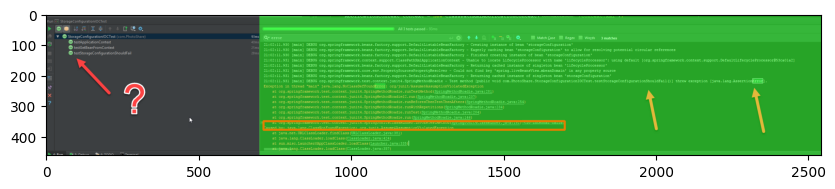

In [366]:
find_paragraph = look_for_text(query_text, sorted_boxes, 5)

if (find_paragraph[0] != None):
    box = sorted_boxes[find_paragraph[0]]
    highlighted_image = add_text_to_image(img_url, [box], 5)
    highlighted_image = highlight_section(highlighted_image, sections, sorted_boxes, find_paragraph)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))

In [367]:
# Save each section to a separate image
def save_section_images(image, rectangles_bbox):
    section_images = []
    for i, rect in enumerate(rectangles_bbox):
        x1, y1 = rect['bounds'][0]
        x2, y2 = rect['bounds'][1]
        section_images.append(image[y1:y2, x1:x2])
        cv2.imwrite(f"section_{i}.png", image[y1:y2, x1:x2])
    return section_images

# section_images = save_section_images(image, rectangles_bbox)

In [368]:
def add_lines_to_image(image_path, sections_):
    # Create a copy of the image
    line_image = cv2.imread(image_path)

    # Draw lines between the sections
    for section in sections_:
        cv2.line(line_image, (section, 0), (section, line_image.shape[0]), (255, 0, 0), 2)

    return line_image

In [369]:
import pandas as pd

data = pd.read_csv("../../data/Masters_CleanedUp.csv")

interesing_images = [
    56185573,
    35439810,
    52974666,
    59833763,
    13158802,
    18315842,
    65162215,
    70403823,
    41376556,
]

# data = data[data['Id'].isin(interesing_images)]

# Iterate over the rows of the DataFrame
for index, row in data.iterrows():
    # Turn ImageUrl into a list
    image_urls = row['ImageUrl'].replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
    image_names = [f"{index}_{i}.png" for i, img in enumerate(image_urls)]
    
    # Update the DataFrame directly
    data.at[index, 'ImageUrl'] = image_urls
    data.at[index, 'ImageName'] = image_names

# Only keep the first 100 rows
data = data.head(100)

In [370]:
# from time import sleep
# import re

# for index, row in data.iterrows():
#     for i, url in enumerate(row['ImageUrl']):
#         try:
#             img = str(row['Id']) + "_" + re.split("[.][w]+", url.split('/')[-1].split('.')[0])[0] + ".png"
#             # Example usage 
#             img_uri = upload_to_gcs(bucket_name, "../../images/Temp/" + img, row['ImageName'][i])
#             img_path = "../../images/Temp/" + img
#             paragraphs = detect_text(img_path)
#             filtered_paragraphs = non_max_suppression(paragraphs, overlap_thresh=0.3)
#             cv2.imwrite(f"../../images/OCR/{img}", add_text_to_image(img_path, filtered_paragraphs))

#             merged_boxes = merge_overlapping_boxes(filtered_paragraphs, threshold=0.001)
#             sorted_boxes = sort_bounding_boxes(merged_boxes)

#             modified_img = add_text_to_image(img_path, sorted_boxes, -1)
#             cv2.imwrite(f"../../images/NoText/{img}", modified_img)

#             sections = detect_sections_more_refined(cv2.imread(img_path), modified_img)
#             print(f"Detected {len(sections) - 1} section(s)")
#             if (sections[0] != 0):
#                 sections.insert(0, 0)
#             if (sections[-1] != image.shape[1]):
#                 sections.append(image.shape[1])
            
#             sectioned_img = add_lines_to_image(img_path, sections)
#             cv2.imwrite(f"../../images/Sectioned/{img}", sectioned_img)

#             rectangles_bbox = []
#             for i in range(len(sections) - 1):
#                 rectangles_bbox.append({"bounds": [(sections[i], 0), (sections[i + 1], image.shape[0])]})
#             if (len(rectangles_bbox) != 0):
#                 get_text_in_rectangle(sorted_boxes, rectangles_bbox)
#             print(sorted_boxes)

#             sleep(30)

#             gemini_response = ask_question(row['NewBody'], img_uri)
#             query_text, explanation = extract_response(gemini_response)
#             # Append the response and the query text to a csv file
#             with open("../../data/Results.csv", "a") as file:
#                 file.write(f'{row['Id']}, "{img}", "{query_text}", "{explanation}"\n')

#             find_paragraph = look_for_text(query_text, sorted_boxes, len(list(query_text))/4)

#             if (find_paragraph[0] != None):
#                 box = sorted_boxes[find_paragraph[0]]
#                 img_url = f"../../images/Temp/{img}"
#                 highlighted_image = add_text_to_image(img_url, [box], 2)
#                 highlighted_image = highlight_section(highlighted_image, sections, sorted_boxes, find_paragraph)
#                 cv2.imwrite(f"../../images/Result/{img}", highlighted_image)

#         except Exception as e:
#             print(f"Error: {e}")
#             continue

# Test

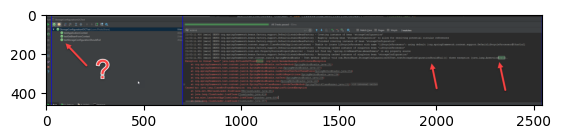

In [371]:
lined_image = add_lines_to_image(img_url, sections)
plt.imshow(cv2.cvtColor(lined_image, cv2.COLOR_BGR2RGB))